# Course assessment: project part 2 (S. De Marco)

## Numerical processing of financial data 

#### Objective
The goal of this project is to fit some implied volatility parametrisations to market option data while studying their no-arbitrage properties.

- Please write commented code. You can also use text cells for your comments and explanations.
- The code must follow the good coding principles (it must be clean, readable, etc.). 
- Graphs must have a title, a legend and their axes must be labeled. 
- At the end, submit your notebooks __and a pdf file of 5 to 8 pages__ into the Moodle Assignment you will find in the section "Assessment: projects".
This separate pdf file is intended to be a (very) short paper : a standalone document that summarizes the work you have carried out in the notebooks and the results you have obtained (being they positive or negative), with figures. It has to be self-contained in the sense that one has to be able to read your report and understand its content without having to look into your notebooks, which will be checked afterwards. 

#### Modules

Feel free to add any other (open-source) module you need.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, display
import scipy.optimize as opt

## Part 1. The SVI parameterisation for the implied volatility, again

$\blacktriangleright$ __New dataset__: we recall that you can download delayed option quotes on the SP500 index from the [CBOE quotes platform](http://www.cboe.com/delayedquote/quote-table) (index symbol: SPX). 
 
$\blacktriangleright$ __TO DO__: In a new notebook, download a new dataset of option prices for one of the available maturities (the classical maturities for SPX options are the third Friday of each month, but you can choose any), filter out quotes that have zero volume, and perform a fitting of the SVI model parameters as done together in class. 

$\blacktriangleright$ Notably, try to take into account the no-arbitrage conditions on the implied volatility smile within the parameter learning process (or, at least, after the learning process).

If you wish to use a set of option prices on some other asset, this is also possible. In any case, provide the data set file together with your notebook.

In the pdf report, explain the procedure you have followed, and present/discuss your results.

******************************************************************

Let's start by loading the data and taking a look at the main information on the stock

In [2]:
info = pd.read_csv('spx_quotedata.csv').iloc[0, :3]

# Extract the first line (header is included by default)
print(info)

SP 500 INDEX          Date: 4 mars 2025 à 08:31 UTC−5
Last: 5849.7202                          Bid: 5807.48
Change:  -104.7798                     Ask: 5925.0898
Name: 0, dtype: object


In [3]:
stock_price = 5849.7202

To compute the log-moneyness for the different strike prices, we need to compute the forward price of the asset. For that, we compute the time to maturity T and determine the risk-free rate r.

Let's compute the value of T for the time to maturity (in years), considering t=0 as of March 4th. We will use the data from the call price of Friday, March 21st

In [4]:
T = (21-4) / 365.25
print(f'The time to maturity T in years is equal to {T:.5f}')

The time to maturity T in years is equal to 0.04654


We look at the the price of the US treasury yield with a 12-months maturity on Bloomberg.

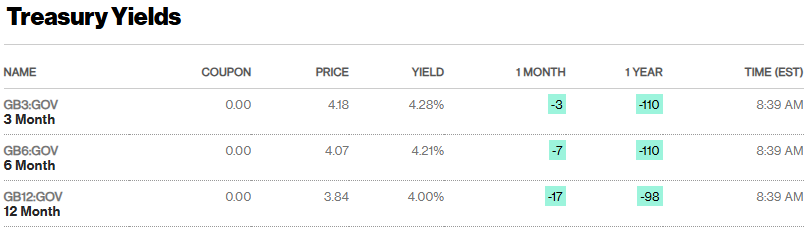

In [5]:
display(Image(filename='US yields.png'))

In [6]:
r = 0.04

Let's compute the Forward price of the stock using as the risk free rate the 12-months US Treasury Yields as of March 4th

In [7]:
Forward = stock_price * np.exp(r * T)
print(f'The forward price is equal to {Forward:.2f}')

The forward price is equal to 5860.62


Let's use the option call quotes on the SPX 500 index of the Friday March 21st

In [8]:
quotes = pd.read_csv('spx_quotedata.csv', header=2)
quotes = quotes[quotes['Expiration Date'] == 'Fri Mar 21 2025']
quotes.head()

,Expiration Date,Calls,Last Sale,Net,Bid,Ask,Volume,IV,Delta,Gamma,...,Puts,Last Sale.1,Net.1,Bid.1,Ask.1,Volume.1,IV.1,Delta.1,Gamma.1,Open Interest.1
2449,Fri Mar 21 2025,SPX250321C00200000,5699.34,-7.2100,5638.1,5649.7,1,0.0000,1.0,0.0,...,SPX250321P00200000,0.05,0.000,0.0,0.05,0,4.2775,0.0000,0.0,4834
2450,Fri Mar 21 2025,SPXW250321C00200000,5629.59,-77.2599,5639.4,5649.0,2,0.0000,1.0,0.0,...,SPXW250321P00200000,0.05,0.000,0.0,0.05,0,4.2439,0.0000,0.0,7
2451,Fri Mar 21 2025,SPX250321C00400000,5499.94,-7.1100,5438.6,5450.2,1,0.0000,1.0,0.0,...,SPX250321P00400000,0.05,0.000,0.0,0.05,0,3.3685,0.0000,0.0,1063
2452,Fri Mar 21 2025,SPXW250321C02300000,0.00,0.0000,3544.5,3554.4,0,1.3014,1.0,0.0,...,SPXW250321P02300000,0.15,0.000,0.0,0.20,30,1.2837,-0.0003,0.0,174
2453,Fri Mar 21 2025,SPX250321C02500000,3504.13,0.0000,3343.8,3355.4,0,0.0000,1.0,0.0,...,SPX250321P02500000,0.10,-0.075,0.0,0.20,20,1.1829,-0.0003,0.0,22579


Let's keep only the Volume, Implied Volatility and Strike columns of the call options, and compute the forward log-moneyness:

In [9]:
call_prices = quotes[['Volume', 'IV', 'Strike']].copy()
call_prices['log_mon'] = np.log(call_prices['Strike'] / Forward)
call_prices.head()

,Volume,IV,Strike,log_mon
2449,1,0.0000,200,-3.377693
2450,2,0.0000,200,-3.377693
2451,1,0.0000,400,-2.684546
2452,0,1.3014,2300,-0.935346
2453,0,0.0000,2500,-0.851965


Let's filter out quotes with zero volume

In [10]:
call_prices = call_prices[call_prices['Volume'] > 0]
call_prices.reset_index(drop=True, inplace=True)
call_prices.head()

,Volume,IV,Strike,log_mon
0,1,0.000,200,-3.377693
1,2,0.000,200,-3.377693
2,1,0.000,400,-2.684546
3,1,0.778,3400,-0.544480
4,2,0.795,3800,-0.433255


We will also delete the 3 first rows of the dataframe, as they contain not meaningful information for our analysis - too far from the money.

In [11]:
call_prices = call_prices.iloc[3:]
call_prices.reset_index(drop=True, inplace=True)
call_prices.head()

,Volume,IV,Strike,log_mon
0,1,0.7780,3400,-0.544480
1,2,0.7950,3800,-0.433255
2,1830,0.6664,4000,-0.381961
3,30,0.7084,4000,-0.381961
4,1,0.6493,4100,-0.357269


Let's compute now the implied total variance $w(T,k)$

Recall:

The implied total variance $w(T,k)$ for maturity $T$ and log-forward moneyness $k = \log \frac K {F_0^T}$ is defined by

$$
w(T,k) = T \, \sigma^2(T, k)
$$

where $\sigma(T, k)$ is the implied volatility for the same maturity and the same log-forward moneyness.

In [12]:
call_prices['Implied_Total_Var'] = T * call_prices['IV']**2
call_prices.head()

,Volume,IV,Strike,log_mon,Implied_Total_Var
0,1,0.7780,3400,-0.544480,0.028172
1,2,0.7950,3800,-0.433255,0.029417
2,1830,0.6664,4000,-0.381961,0.020669
3,30,0.7084,4000,-0.381961,0.023357
4,1,0.6493,4100,-0.357269,0.019622


Let's use the function least_squares to parameterize the SVI model to our call options.

We recall that __the SVI parameterisation__ proposed by J. Gatheral (2004) to model the total implied variance smile for a fixed maturity $T$ :

\begin{equation}
w_\mathrm{SVI}(k) = a + b \left(\rho (k - \bar k) + \sqrt{(k - \bar k)^2 + \sigma^2} \right),
\qquad k \in \mathbb R,
\end{equation}

where the parameters $(a, b, \rho, \bar k, \sigma)$ satisfy

$$
b > 0 \qquad \quad \rho \in (-1,1) \qquad \quad \sigma > 0, \qquad \quad a, \bar k \in \mathbb R.
$$

Since $\min_{k \in \mathbb R} w_\mathrm{SVI}(k) = a + b \, \sigma \, \sqrt{1 - \rho^2}$, in general we also have to impose the condition $a + b \, \sigma \, \sqrt{1 - \rho^2} > 0$ in order to grant positivity of the function $w_\mathrm{SVI}$.


In [13]:
def SVI(k, a, b , rho, k_bar, sig):
    total_variance = a + b * (rho * (k - k_bar) + np.sqrt((k - k_bar)**2 + sig**2))
    
    return total_variance

def SVI_two_arguments(theta, k):
    a, b , rho, k_bar, sig = theta
    
    return SVI(k, a, b , rho, k_bar, sig)

def fct_least_squares(theta, log_mon, tot_implied_variance):
    """
    theta                : the vector of SVI parameters
    log_mon              : log-forward moneyness k (float or double)
    tot_implied_variance : the target total implied variance (float or double)
    
    Returns : the objective function (without the square) to be injected
    in the least-square problem
    """
    return SVI_two_arguments(theta, log_mon) - tot_implied_variance

We have to choose a starting point for the minimum search: let use the same as in the practice session in class, but we could also try with another one.

In [14]:
tot_variance = call_prices['Implied_Total_Var']
log_mon = call_prices['log_mon']

In [15]:
## Choice of initial point
a_init = np.min(tot_variance) / 2
b_init = 0.1
rho_init = -0.8
k_bar_init = 0.
sig_init = 0.1

Let us have a look at our initial guess for SVI:

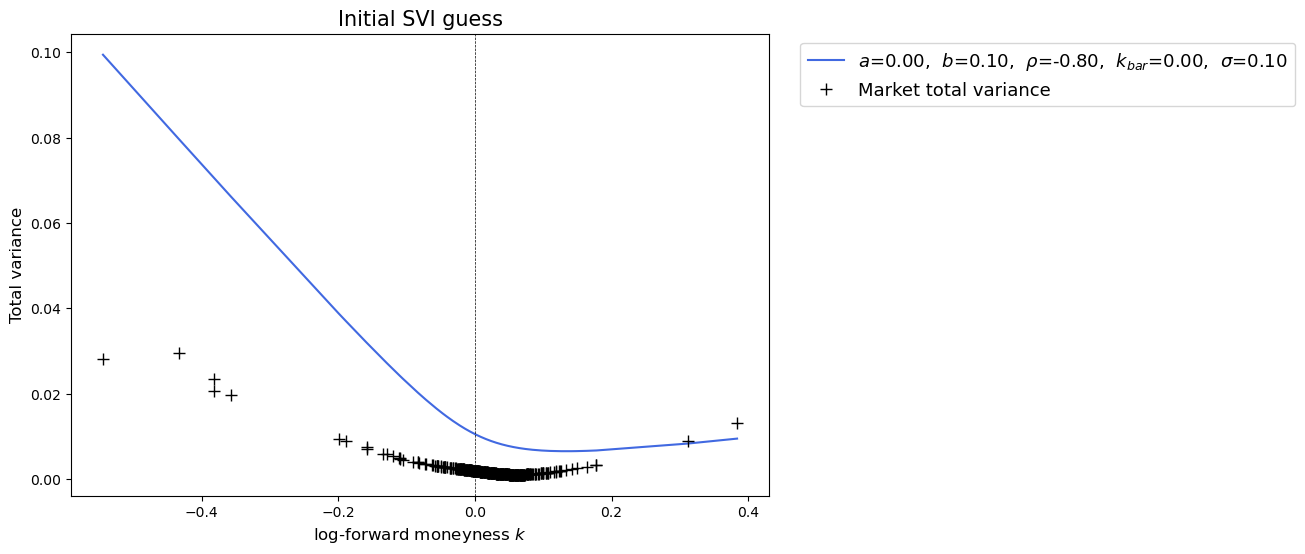

In [16]:
plt.figure(figsize=(9,6))

total_variances_init = SVI(log_mon , a_init, b_init, rho_init, k_bar_init, sig_init)

plt.plot(log_mon, total_variances_init,
         color='royalblue', linewidth=1.5, 
         label=r"$a$=%1.2f,  $b$=%1.2f,  $\rho$=%1.2f,  $k_{bar}$=%1.2f,  $\sigma$=%1.2f" %(a_init,b_init,rho_init,k_bar_init,sig_init))

plt.plot(log_mon, tot_variance,
         color='black', linewidth=0., marker="+", markersize=8, label="Market total variance")

plt.axvline(0., linestyle="--", linewidth=0.5, color="k")

plt.xlabel(r"log-forward moneyness $k$", fontsize=12)
plt.ylabel("Total variance", fontsize=12)
plt.title(r"Initial SVI guess", fontsize=15)

plt.legend(loc=9, fontsize=13, bbox_to_anchor=(1.4, 1.0), ncol=1)

Let's now opimize the SVI parameters using the least-square method.

In [17]:
# Put bounds on the parameters
lower = np.array([0,   # a
                  0.,   # b
                  -1,  # rho
                  -0.5, # k_bar
                  0.])  # sigma

upper = np.array([2, # a
                  2.,  # b
                  1,  # rho
                  0.5, # k_bar
                  1.]) # sigma

SVI_param_bounds = (lower, upper)

theta_init = np.array([a_init, b_init, rho_init, k_bar_init, sig_init])

# Optimization
result = opt.least_squares(fun = fct_least_squares,
                           x0 = theta_init, #initial guess, 
                           bounds = SVI_param_bounds, #bounds on the parameters
                           args = (log_mon, tot_variance), #additional arguments for the LS objective
                           verbose = 1)

## The optimized parameters
a_star, b_star, rho_star, k_bar_star, sig_star = result.x

`ftol` termination condition is satisfied.
Function evaluations 23, initial cost 2.0307e-02, final cost 8.5061e-05, first-order optimality 5.17e-08.


Let's have a look at our SVI fit of implied variance:

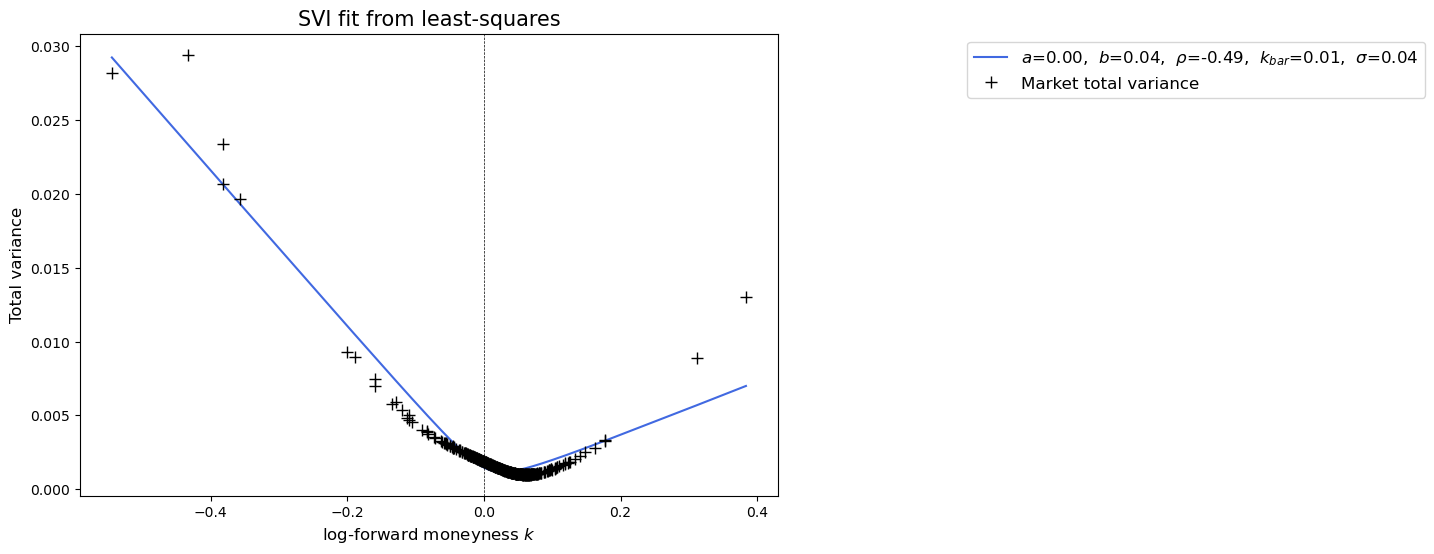

In [18]:
total_variances_fit = SVI_two_arguments(result.x, log_mon)

plt.figure(figsize=(9,6))

plt.plot(log_mon, total_variances_fit,
         color='royalblue', linewidth=1.5, 
         label=r"$a$=%1.2f,  $b$=%1.2f,  $\rho$=%1.2f,  $k_{bar}$=%1.2f,  $\sigma$=%1.2f" %(a_star, b_star, rho_star, k_bar_star, sig_star))

plt.plot(log_mon, tot_variance,
         color='black', linewidth=0., marker="+", markersize=8, label="Market total variance")


plt.axvline(0., linestyle="--", linewidth=0.5, color="k")

plt.xlabel(r"log-forward moneyness $k$", fontsize=12)
plt.ylabel("Total variance", fontsize=12)
plt.title(r"SVI fit from least-squares", fontsize=15)

plt.legend(loc=9, fontsize=12, bbox_to_anchor=(1.6, 1.0), ncol=1)

Let's study the fit of our model on the corresponding implied volatility

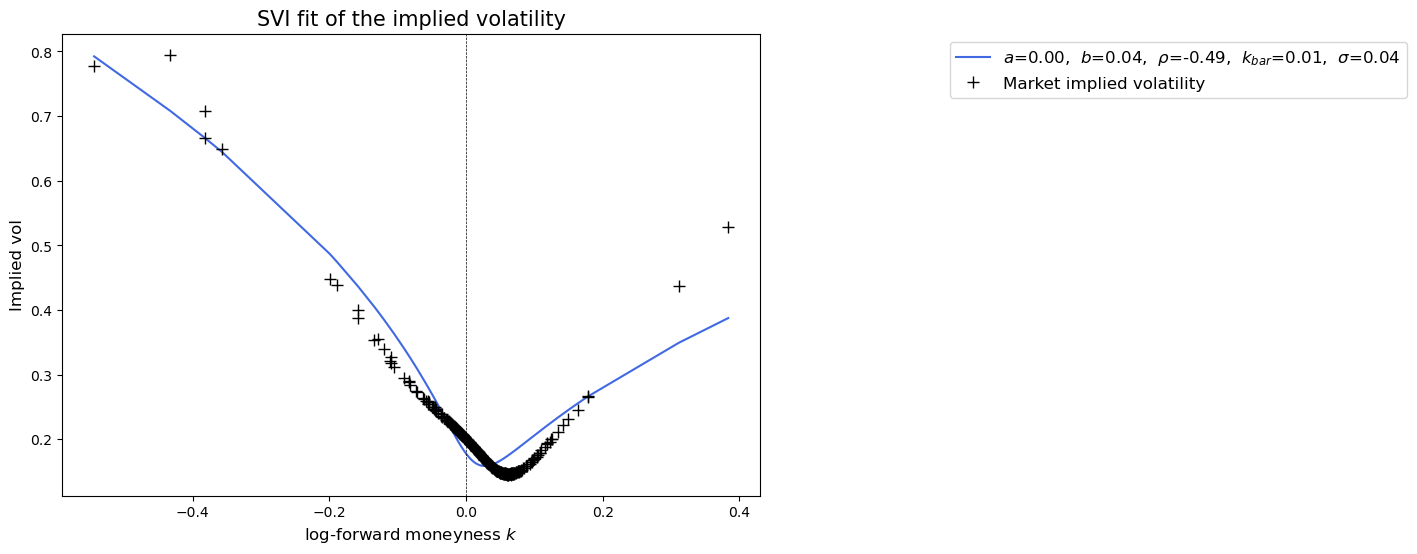

In [19]:
#####################################
## Plot of SVI fit of implied vol
#####################################
implied_vols_fit = np.sqrt(total_variances_fit/T)

plt.figure(figsize=(9,6))

plt.plot(log_mon, implied_vols_fit,
         color='royalblue', linewidth=1.5, 
         label=r"$a$=%1.2f,  $b$=%1.2f,  $\rho$=%1.2f,  $k_{bar}$=%1.2f,  $\sigma$=%1.2f" %(a_star, b_star, rho_star, k_bar_star, sig_star))

plt.plot(log_mon, np.sqrt(tot_variance/T),
         color='black', linewidth=0., marker="+", markersize=8, label="Market implied volatility")

plt.axvline(0., linestyle="--", linewidth=0.5, color="k")

plt.xlabel(r"log-forward moneyness $k$", fontsize=12)
plt.ylabel("Implied vol", fontsize=12)
plt.title(r"SVI fit of the implied volatility", fontsize=15)

plt.legend(loc=9, fontsize=12, bbox_to_anchor=(1.6, 1.0), ncol=1)

<span style="color: red;">Essayer de comprendre pourquoi notre courbe n'épouse pas parfaitement la courbe, dans les deux cas. Voir s'il est normal de devoir calculer la log-moneyness nous-mêmes pour répondre au problème. Tester si en retirant les outliers on ne parvient pas à obtenir quelque chose de plus sympa</span>

Let's now test a first sufficient condition to assess that there is no arbitrage: Call price decay

This condition ensures that the price of a call option goes to zero as the strike price becomes very large.

Test that $\lim_{k \to \infty} d_1(k,w(k)) = -\infty$, is satisfied if

$$
\lim_{k \to \infty} \frac{w(k)}{2 k} < 1.
$$

We know that the SVI parameterisation satisfies this condition as soon as
$$ b (1 + \rho) < 2. $$

which is a constraint on the maximum asymptotic slope of the SVI parameterisation for large $k$.

In [20]:
def test_slope(b, rho):
    right_slope = b * (1 + rho)
            
    print("\n Right slope b*(1 + rho) = %1.2f" %right_slope)
    
    assert(right_slope < 2)
    
    print("\n Slope test: OK \n")
    
    pass

test_slope(b_star, rho_star)


 Right slope b*(1 + rho) = 0.02

 Slope test: OK 



This first condition is verified.

Let now check the second sufficient condition: No-butterfly arbitrage

This condition ensures that the implied volatility surface does not allow for butterfly arbitrage. Butterfly arbitrage occurs when there are mispricings in options with different strikes but the same maturity.
    
- The condition involves a mathematical expression that ensures the convexity of the call price with respect to the strike price. Convexity means that the second derivative of the call price with respect to the strike price is non-negative.
- This is also known as the "no-butterfly arbitrage condition" because it prevents opportunities for arbitrage by ensuring that the call price curve is properly shaped.

We accept to test it numerically (...and therefore only partially!) over a grid of values for $k$

We have the following computation to test:

$$
g_{\mathrm{SVI}}(k) := 
\frac 12 w''_{\mathrm{SVI}}(k)
+ \left(1-\frac{k \, w'_{\mathrm{SVI}}(k)}{2 \, w_{\mathrm{SVI}}(k)}\right)^2 -\frac {(w'_{\mathrm{SVI}}(k))^2}{4}\left(\frac 1{w_{\mathrm{SVI}}(k)}+\frac{1}{4}\right) \geq 0,
\qquad \forall k \in \mathbb R
$$

with

$$
w'_\mathrm{SVI}(k) = b \left( \rho + \frac{k - \bar{k}}{\sqrt{(k - \bar{k})^2 + \sigma^2}} \right)
, \qquad 
w''_\mathrm{SVI}(k) = \frac{b \sigma^2}{((k - \bar{k})^2 + \sigma^2)^{3/2}}

$$



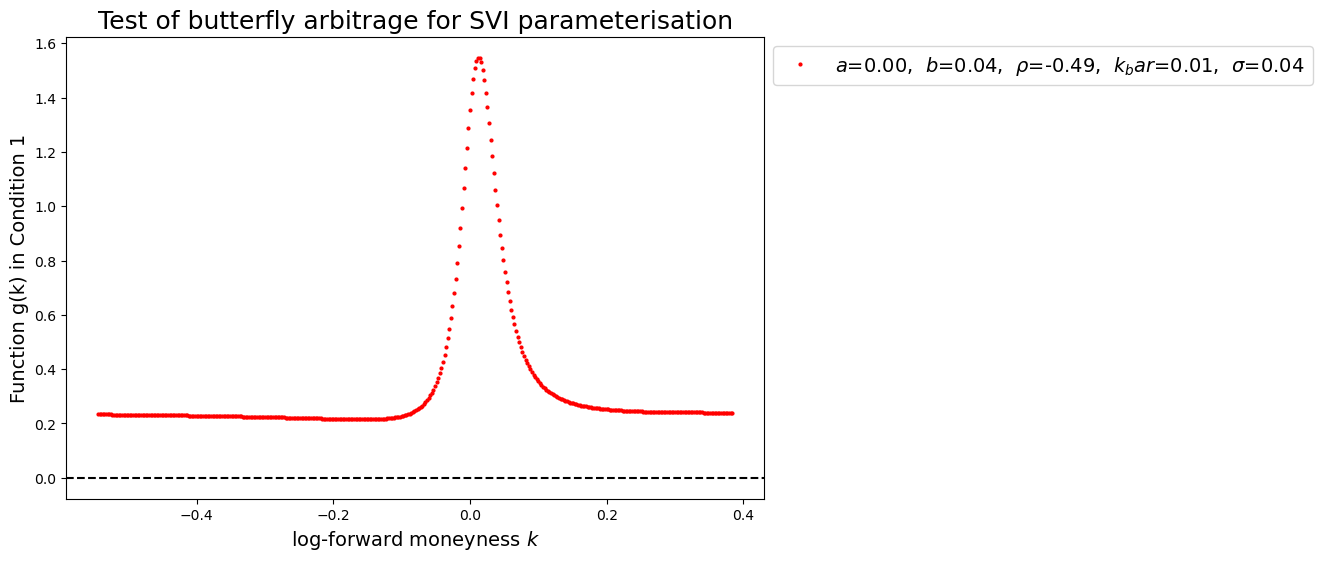


 Butterfly arbitrage test: OK 



In [21]:
def test_butterfly_arbitrage(k, a, b, rho, k_bar, sig):
    square_rt = np.sqrt( (k - k_bar)*(k - k_bar) + sig*sig)
    
    w = SVI(k, a, b, rho, k_bar, sig)
    
    first_der_w = b*rho + b*(k-k_bar)/ square_rt
    
    second_der_w = b*sig*sig / square_rt**3
    
    g = 0.5 * second_der_w + (1 - k*first_der_w/(2*w))**2 - first_der_w**2 * (1/w + 1/4) / 4   
    
    return g

def numerical_test_butterfly_arbitrage(a, b, rho, k_bar, sig, log_mon_lower = min(log_mon), log_mon_upper = max(log_mon)):
    
    log_moneyness_test_grid = np.linspace(log_mon_lower, log_mon_upper, 400)
    
    test_fct_g = test_butterfly_arbitrage(log_moneyness_test_grid, a, b, rho, k_bar, sig)

    plt.figure(figsize=(9,6))

    plt.plot( log_moneyness_test_grid , test_fct_g , color="red", linewidth=0., marker=".", markersize=4, \
             label=r"$a$=%1.2f,  $b$=%1.2f,  $\rho$=%1.2f,  $k_bar$=%1.2f,  $\sigma$=%1.2f" %(a,b,rho,k_bar,sig))

    plt.axhline(0., linestyle="--", color="k")

    plt.xlabel("log-forward moneyness $k$", fontsize=14)
    plt.ylabel("Function g(k) in Condition 1", fontsize=14)
    plt.title(r"Test of butterfly arbitrage for SVI parameterisation", fontsize=18)

    plt.legend(loc=9, fontsize=14, bbox_to_anchor=(1.4, 1.0), ncol=1)

    plt.show()
    
    # We test whether all the entries of the array test_fct_g have positive values
    assert( (test_fct_g >= 0).all )
    
    print("\n Butterfly arbitrage test: OK \n")

    pass
    
numerical_test_butterfly_arbitrage(a_star, b_star, rho_star, k_bar_star, sig_star)

We can now affirm that the 2 sufficient conditions for the SVI parameterisation with no arbitrage are satisfied.

## Part 2. The SSVI ("surface SVI") sub-family

Below, you will recognize the SSVI parametric model that was introduced in the notebook No_arbitrage_implied_vol.ipynb

The SSVI parameterisation of [Gatheral and Jacquier, 2014](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2033323) is constructed as follows: first define the

### SSVI slice

$$
w_\mathrm{SSVI}(k; \theta, \varphi, \rho) = \frac{\theta} 2 \Bigl(1 + \varphi \, \rho k + \sqrt{(\varphi \, k + \rho)^2 + 1 - \rho^2} \Bigr),
\qquad k \in \mathbb R
$$

where 

$$
\theta \ge 0, \qquad \varphi \ge 0, \qquad \rho \in (-1,1).
$$

Note that $w_\mathrm{SSVI}(k) \big|_{k=0} = \theta$, so that the parameter $\theta$ corresponds to the ATM total variance.

+ Thanks to the reduced complexity (3 parameters instead of 5), the no-butterfly arbitrage conditions 1) and 3) from the lecture notes on a SSVI slice can be replaced with much simpler conditions on the parameters $(\theta, \varphi, \rho)$, given in [Gatheral and Jacquier 2014], Theorem 4.2, which states that the no-arbitrage conditions 1) and 3) are satisfied if

$$
\left\{
\begin{aligned}
&\theta \, \varphi \, (1+|\rho|) < 4
\\
&\theta \, \varphi^2 \, (1+|\rho|) \le 4.
\end{aligned}
\right.
$$

$\blacktriangleright$ __TO DO__: perform a fitting of the SSVI slice parameters (as opposed to SVI) to the same market data already used in Part 1 (for the same fixed maturity).

Take into account the no-arbitrage conditions on the SSVI parameterisation within (or, at least, after) the parameter learning process. In the pdf report, explain in details the procedure you have followed, and present/discuss your results.

Let's define the new SSVI slice

In [22]:
def SSVI(k, theta, phi, rho):
    total_variance = theta /2 * (1 + rho * phi * k + np.sqrt((phi * k + rho)**2 + (1 - rho**2)))
    
    return total_variance

def SSVI_two_arguments(param, k):
    theta, phi, rho = param
    
    return SSVI(k, theta, phi, rho)

def fct_least_squares_2(param, log_mon, tot_implied_variance):
    """
    theta                : the vector of SVI parameters
    log_mon              : log-forward moneyness k (float or double)
    tot_implied_variance : the target total implied variance (float or double)
    
    Returns : the objective function (without the square) to be injected
    in the least-square problem
    """
    return SSVI_two_arguments(param, log_mon) - tot_implied_variance

In [23]:
## Choice of initial point
theta_init = 0.1 # sup to 0
phi_init = 4 # sup to 0
rho_init = -0.2 # between -1 and 1

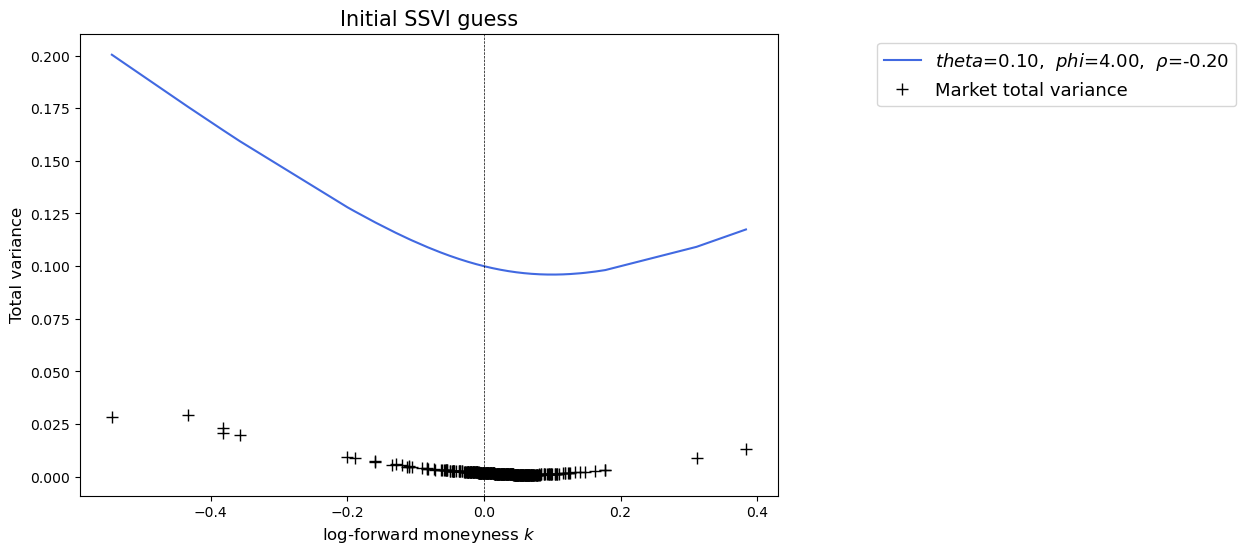

In [24]:
plt.figure(figsize=(9,6))

total_variances_init = SSVI(log_mon , theta_init, phi_init, rho_init)

plt.plot(log_mon, total_variances_init,
         color='royalblue', linewidth=1.5, 
         label=r"$theta$=%1.2f,  $phi$=%1.2f,  $\rho$=%1.2f" %(theta_init,phi_init,rho_init))

plt.plot(log_mon, tot_variance,
         color='black', linewidth=0., marker="+", markersize=8, label="Market total variance")

plt.axvline(0., linestyle="--", linewidth=0.5, color="k")

plt.xlabel(r"log-forward moneyness $k$", fontsize=12)
plt.ylabel("Total variance", fontsize=12)
plt.title(r"Initial SSVI guess", fontsize=15)

plt.legend(loc=9, fontsize=13, bbox_to_anchor=(1.4, 1.0), ncol=1)

In [25]:
# Put bounds on the parameters
lower = np.array([0,   # theta
                  0.,   # phi
                  -1]) # rho

upper = np.array([100,   # theta
                  100,   # phi
                  1]) # rho

SSVI_param_bounds = (lower, upper)

param_init = np.array([theta_init, phi_init, rho_init])

# Optimization
result = opt.least_squares(fun = fct_least_squares_2,
                           x0 = param_init, #initial guess, 
                           bounds = SSVI_param_bounds, #bounds on the parameters
                           args = (log_mon, tot_variance), #additional arguments for the LS objective
                           verbose = 1)

## The optimized parameters
theta_star, phi_star, rho_star = result.x

`gtol` termination condition is satisfied.
Function evaluations 15, initial cost 1.5691e+00, final cost 1.0631e-04, first-order optimality 1.23e-09.


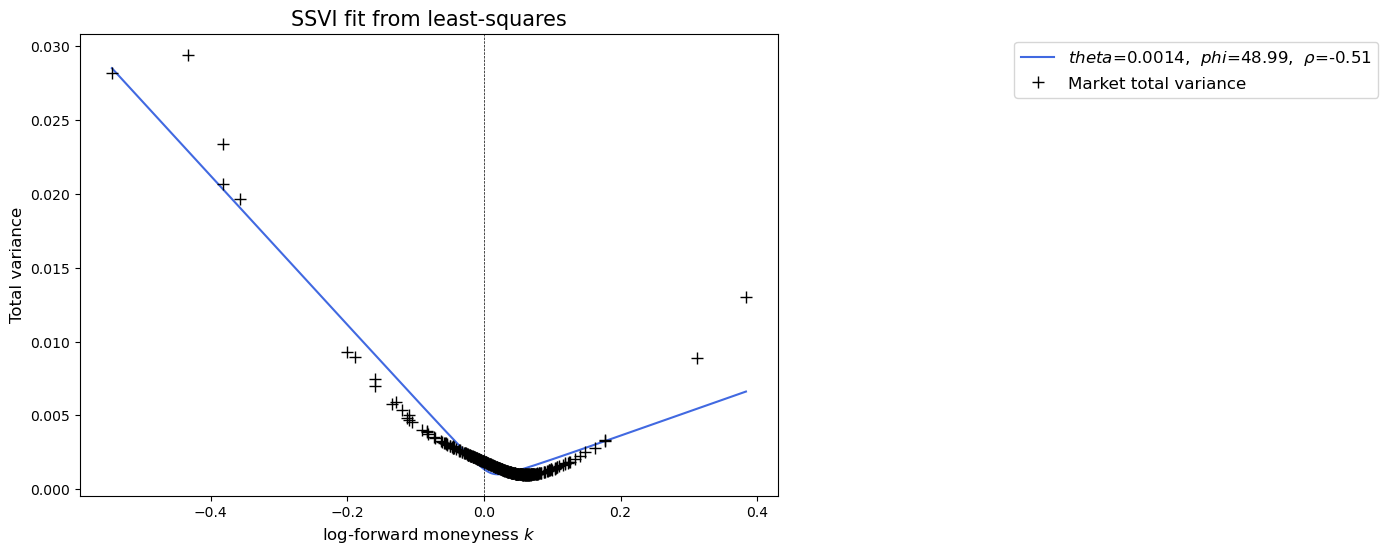

In [26]:
total_variances_fit = SSVI_two_arguments(result.x, log_mon)

plt.figure(figsize=(9,6))

plt.plot(log_mon, total_variances_fit,
         color='royalblue', linewidth=1.5, 
         label=r"$theta$=%1.4f,  $phi$=%1.2f,  $\rho$=%1.2f" %(theta_star, phi_star, rho_star))

plt.plot(log_mon, tot_variance,
         color='black', linewidth=0., marker="+", markersize=8, label="Market total variance")


plt.axvline(0., linestyle="--", linewidth=0.5, color="k")

plt.xlabel(r"log-forward moneyness $k$", fontsize=12)
plt.ylabel("Total variance", fontsize=12)
plt.title(r"SSVI fit from least-squares", fontsize=15)

plt.legend(loc=9, fontsize=12, bbox_to_anchor=(1.6, 1.0), ncol=1)

Let now test the no-arbitrage condition for this SSVI parameterisation.

In [27]:
def no_arbitrage_test(theta, phi, rho):
        
    assert(theta * phi * (1 + np.abs(rho)) < 4)
    
    print("\n First condition: OK \n")
    
    pass

    assert(theta * phi**2 * (1 + np.abs(rho)) <= 4)
    
    print("\n Second condition: OK \n")
    
    pass

no_arbitrage_test(theta_star, phi_star, rho_star)


 First condition: OK 



AssertionError: 

<span style="color: red;">Essayer de comprendre pourquoi dans cette configuration la deuxième assertion de non-arbitrage n'est pas validée. Pourquoi serait-elle valide selon le premier modèle mais pas celui-là? Voir si pas possible de poser dans les lower et upper bound des conditons pour respecter le cadre. Parait pas immédiat car car pas possible de majorer tout le temps par une des deux conditions (dépend de si phi est inf à 1 ou pas), et potentiellement problème de division par zéro.</span>

### Full SSVI surface

So far, we have only worked with fixed-maturity slices of the implied volatility surface. We haven't defined a function $w_\mathrm{SSVI}$ of $(T, k)$ yet.

Given:

+ a curve $T \mapsto \theta_T \ge 0$ (representing at-the-money total implied variance $w(T,0)$ for maturity $T$)


+ a function $\varphi: \mathbb R_+ \to \mathbb R_+$,

the full __Surface SVI__ model is defined by

$$
\begin{aligned}
w_\mathrm{SSVI}(T, k) 
&= 
w_\mathrm{SSVI}(k; \ \theta_{T}, \ \varphi(\theta_T), \ \rho) 
\\
&= \frac{\theta_{T}} 2 \Bigl(1 + \varphi(\theta_{T}) \rho k + \sqrt{\bigl(\varphi(\theta_{T}\bigr) k + \rho)^2 + 1 - \rho^2} \Bigr),
\qquad k \in \mathbb R, T > 0.
\end{aligned}
$$

The no-calendar spread arbitrage condition we have seen in the lectures:
  
2) The function $T \mapsto w_\mathrm{SSVI}(T, k) $ is increasing, for every $k \in \mathbb R$,

can also be reformulated as a simple tractable condition on the functions $\theta_\cdot$ and $\varphi(\cdot)$, see [Gatheral and Jacquier 2014], Theorem 4.1:

\[
\begin{cases}
T \mapsto \theta_T \text{ is increasing} \\
0 \le \partial_\theta (\theta \, \varphi(\theta)) \le \frac{1}{\rho^2} \left(1+ \sqrt{1-\rho^2}\right) \varphi(\theta) \quad \forall \theta,
\end{cases}
\]

where, in the second line, we have supposed that the functions $\theta_\cdot$ and $\varphi(\cdot)$ are differentiable.

[Gatheral and Jacquier 2014] also provide parametric examples of functions $T \mapsto \theta_T$ and $\theta \mapsto \varphi(\theta)$ that satisfy the no-calendar spread arbitrage condition above (but you can still try to desing your own, based on the observation of market data).

$\blacktriangleright$ __TO DO__: dowload and use option data for at least two different maturities $T_1$ and $T_2$ (or more if you wish), observed at the same date $t$. Make a parametric choice for the functions $T \mapsto \theta_T$ and $\theta \mapsto \varphi(\theta)$ and then perform a fitting of the full SSVI surface model $w_\mathrm{SSVI}(T, k)$ to your target maturities.

Take into account the no-arbitrage conditions on SSVI within (or, at least, after) the parameter learning process. In the pdf report, explain in details the procedure you have followed, and present/discuss your results.